![alt text](https://drive.google.com/uc?export=view&id=1UXScsVx_Wni_JuDdB8LeTnM6jsPfIwkW)

Proprietary content. © Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.

# Sentiment Classification

### Dataset
- Dataset of 50,000 movie reviews from IMDB, labeled by sentiment positive (1) or negative (0)
- Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers).
- For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".
- As a convention, "0" does not stand for a specific word, but instead is used to encode any unknown word.

Command to import data
- `from tensorflow.keras.datasets import imdb`

In [1]:
from random import seed
seed(10)
from tensorflow.random import set_seed
set_seed(10)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, LSTM, TimeDistributed, Flatten, Dense

### Import the data (2 Marks)
- Use `imdb.load_data()` method
- Get train and test set
- Take 10000 most frequent words

In [6]:
from keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
data = np.concatenate((train_data, test_data), axis=0)
labels = np.concatenate((train_labels, test_labels), axis=0)

17473536/17464789 [==============================] - 0s 0us/step


### Pad each sentence to be of same length (2 Marks)
- Take maximum sequence length as 300

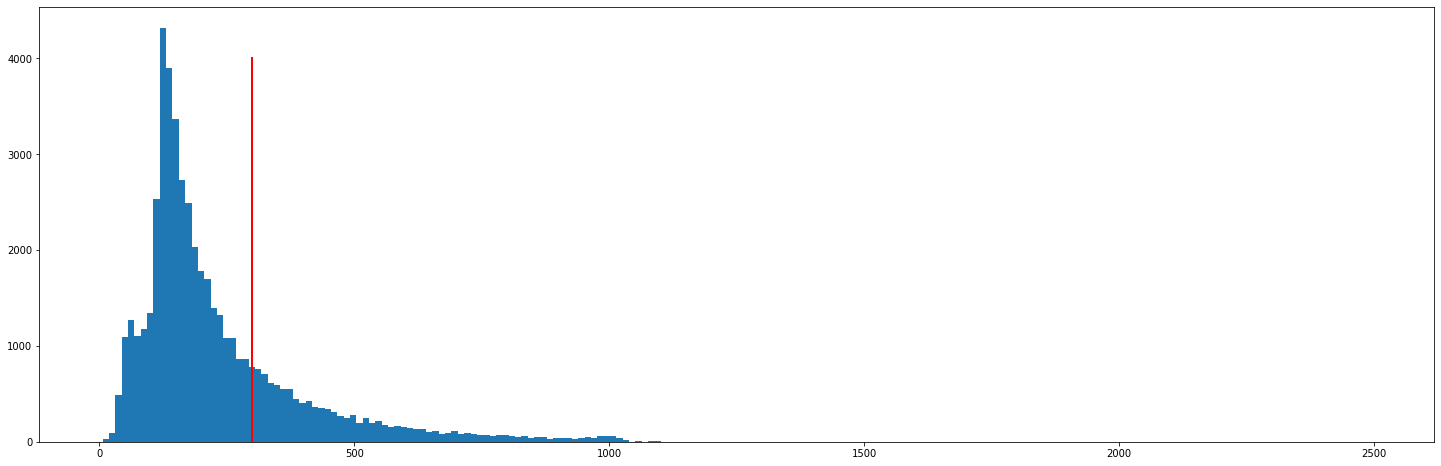

Average review length: 234.75892
Standard deviation: 173
No of reviews with length below 300: 38583


In [7]:
length = [len(i) for i in data]
plt.figure(figsize=(25,8))
plt.hist(length, bins= 200)
plt.plot([300, 300], [0, 4000], 'r', linewidth=2.0)
plt.show()
print("Average review length: {}".format(np.mean(length)))
print("Standard deviation: {}".format(round(np.std(length))))
print("No of reviews with length below 300: {}".format(sum(i < 301 for i in length)))

In [8]:
from keras.preprocessing.sequence import pad_sequences
data_padded = pad_sequences(data, padding='post', maxlen=300)

### Print shape of features & labels (2 Marks)

Number of review, number of words in each review

In [9]:
print('Number of reviews: {}, Number of words in each review: {}'.format(data_padded.shape[0],data_padded.shape[1]))

Number of reviews: 50000, Number of words in each review: 300


Number of labels

In [10]:
print('Number of labels: {}'.format(labels.shape[0]))

Number of labels: 50000


### Print value of any one feature and it's label (2 Marks)

Feature value

In [11]:
data_padded[0]

array([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458,
       4468,   66, 3941,    4,  173,   36,  256,    5,   25,  100,   43,
        838,  112,   50,  670,    2,    9,   35,  480,  284,    5,  150,
          4,  172,  112,  167,    2,  336,  385,   39,    4,  172, 4536,
       1111,   17,  546,   38,   13,  447,    4,  192,   50,   16,    6,
        147, 2025,   19,   14,   22,    4, 1920, 4613,  469,    4,   22,
         71,   87,   12,   16,   43,  530,   38,   76,   15,   13, 1247,
          4,   22,   17,  515,   17,   12,   16,  626,   18,    2,    5,
         62,  386,   12,    8,  316,    8,  106,    5,    4, 2223, 5244,
         16,  480,   66, 3785,   33,    4,  130,   12,   16,   38,  619,
          5,   25,  124,   51,   36,  135,   48,   25, 1415,   33,    6,
         22,   12,  215,   28,   77,   52,    5,   14,  407,   16,   82,
          2,    8,    4,  107,  117, 5952,   15,  256,    4,    2,    7,
       3766,    5,  723,   36,   71,   43,  530,  4

Label value

In [12]:
labels[0]

1

### Decode the feature value to get original sentence (2 Marks)

First, retrieve a dictionary that contains mapping of words to their index in the IMDB dataset

In [13]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

1654784/1641221 [==============================] - 0s 0us/step


Now use the dictionary to get the original words from the encodings, for a particular sentence

In [14]:
print(" ".join([reverse_word_index.get(n-3, '#') for n in data_padded[1]]))

# big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal # the hair is big lots of boobs # men wear those cut # shirts that show off their # sickening that men actually wore them and the music is just # trash that plays over and over again in almost every scene there is trashy music boobs and # taking away bodies and the gym still doesn't close for # all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Get the sentiment for the above sentence
- positive (1)
- negative (0)

In [16]:
labels[1]

0

In [18]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data_padded, labels, test_size=0.20, random_state=0)

### Define model (10 Marks)
- Define a Sequential Model
- Add Embedding layer
  - Embedding layer turns positive integers into dense vectors of fixed size
  - `tensorflow.keras` embedding layer doesn't require us to onehot encode our words, instead we have to give each word a unique integer number as an id. For the imdb dataset we've loaded this has already been done, but if this wasn't the case we could use sklearn LabelEncoder.
  - Size of the vocabulary will be 10000
  - Give dimension of the dense embedding as 100
  - Length of input sequences should be 300
- Add LSTM layer
  - Pass value in `return_sequences` as True
- Add a `TimeDistributed` layer with 100 Dense neurons
- Add Flatten layer
- Add Dense layer

In [35]:
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=100, input_length=300))
model.add(LSTM(units=100, return_sequences=True, dropout=0.2))
model.add(TimeDistributed(Dense(100)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

### Compile the model (2 Marks)
- Use Optimizer as Adam
- Use Binary Crossentropy as loss
- Use Accuracy as metrics

In [36]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

### Print model summary (2 Marks)

In [37]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 300, 100)          1000000   
                                                                 
 lstm_3 (LSTM)               (None, 300, 100)          80400     
                                                                 
 time_distributed_3 (TimeDis  (None, 300, 100)         10100     
 tributed)                                                       
                                                                 
 flatten_3 (Flatten)         (None, 30000)             0         
                                                                 
 dense_7 (Dense)             (None, 1)                 30001     
                                                                 
Total params: 1,120,501
Trainable params: 1,120,501
Non-trainable params: 0
____________________________________________

### Fit the model (2 Marks)

In [38]:
history = model.fit(train_X, np.array(train_y), batch_size=300, epochs=3, validation_split=0.1, verbose=1)

Epoch 1/3
120/120 [==============================] - 7s 42ms/step - loss: 0.4134 - accuracy: 0.7919 - val_loss: 0.2830 - val_accuracy: 0.8875
Epoch 2/3
120/120 [==============================] - 5s 41ms/step - loss: 0.2256 - accuracy: 0.9108 - val_loss: 0.2736 - val_accuracy: 0.8878
Epoch 3/3
120/120 [==============================] - 5s 39ms/step - loss: 0.1824 - accuracy: 0.9288 - val_loss: 0.2973 - val_accuracy: 0.8827


### Evaluate model (2 Marks)

In [39]:
results = model.evaluate(test_X, test_y)

313/313 [==============================] - 3s 10ms/step - loss: 0.2897 - accuracy: 0.8855


In [40]:
from sklearn.metrics import confusion_matrix
predict_y = (model.predict(test_X) > 0.5).astype("int32").flatten()
confusion_matrix(test_y, predict_y)

array([[4457,  536],
       [ 609, 4398]])

### Predict on one sample (2 Marks)

In [41]:
print('Prediction: {} | Ground Truth: {}'.format(((model.predict(test_X[0].reshape(-1,300)) > 0.5).astype("int32").flatten()), test_y[0]))

Prediction: [1] | Ground Truth: 1
